In [89]:
from glob import glob
from os.path import join
import json

from tensorboard.backend.event_processing import event_accumulator
import matplotlib.pyplot as plt

DATA_DIR = "TODO"

# Behavior Cloning: "Walker2d-v4/Hopper-v4"

In [90]:
method = "bc"

for env_name in ["Walker2d", "Hopper"]:
    print("Task:", f"{env_name}-v4")

    for event_dir in sorted(glob(f"{DATA_DIR}/*{method}_{env_name}*", recursive=True)):
        with open(join(event_dir, "config.json"), "r") as f:
            config = json.load(f)
            if config["seed"] != 3: continue
            if config["num_agent_train_steps_per_iter"] != 1000: continue
        
        ea = event_accumulator.EventAccumulator(event_dir)
        ea.Reload()

        expert_mean = ea.Scalars('Expert_AverageReturn')[-1].value
        expert_std = ea.Scalars('Expert_StdReturn')[-1].value

        actor_mean = ea.Scalars('Eval_AverageReturn')[-1].value
        actor_std = ea.Scalars('Eval_StdReturn')[-1].value

        print("Expert:", f"{round(expert_mean)} ({round(expert_std)})")
        print("Actor:", f"{round(actor_mean)} ({round(actor_std)})", "\t", f"{actor_mean/expert_mean*100:.2f}%")
        print()

Task: Walker2d-v4
Expert: 4789 (1345)
Actor: 1859 (2001) 	 38.82%

Task: Hopper-v4
Expert: 3716 (3)
Actor: 1016 (108) 	 27.35%



# Behavior Cloning: Tuning "num_agent_train_steps_per_iter" for "Hopper-v4"

In [96]:
method = "bc"
env_name = "Hopper"

means = []
stds = []
times = []

training_steps = [1, 10, 100, 1000, 10000, 100000]

for num_agent_train_steps_per_iter in training_steps:
    for event_dir in sorted(glob(f"{DATA_DIR}/*{method}_{env_name}*", recursive=True)):
        with open(join(event_dir, "config.json"), "r") as f:
            config = json.load(f)
            if config["seed"] != 3: continue
            if config["num_agent_train_steps_per_iter"] != num_agent_train_steps_per_iter: continue
        
        ea = event_accumulator.EventAccumulator(event_dir)
        ea.Reload()

        mean = ea.Scalars('Eval_AverageReturn')[-1].value
        std = ea.Scalars('Eval_StdReturn')[-1].value
        time = ea.Scalars('TimeSinceStart')[-1].value

        means.append(mean)
        stds.append(std)
        times.append(time)

        break

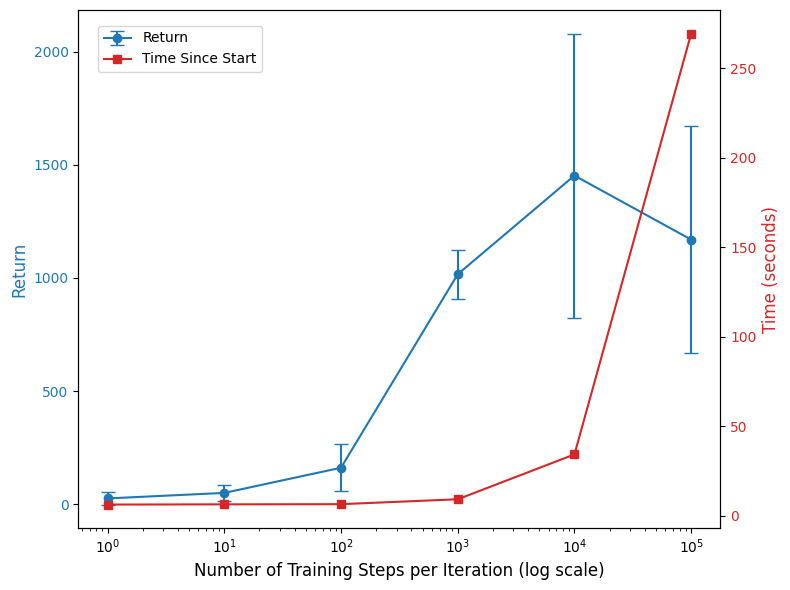

In [124]:
fig, ax1 = plt.subplots(figsize=(8, 6))

ax1.set_xlabel("Number of Training Steps per Iteration (log scale)", fontsize=12)
ax1.set_ylabel("Return", fontsize=12, color="tab:blue")
ax1.errorbar(training_steps, means, yerr=stds, fmt='-o', capsize=5, color="tab:blue", label="Return")
ax1.tick_params(axis='y', labelcolor="tab:blue")
ax1.set_xscale('log')

ax2 = ax1.twinx()
ax2.set_ylabel("Time (seconds)", fontsize=12, color="tab:red")
ax2.plot(training_steps, times, '-s', color="tab:red", label="Time Since Start")
ax2.tick_params(axis='y', labelcolor="tab:red")

fig.legend(loc="upper left", bbox_to_anchor=(0.12, 0.96))
plt.tight_layout()

output_file = f"{env_name}_{method}_performance_vs_time.pdf"
plt.savefig(join(DATA_DIR, output_file), format='pdf')

plt.show()

# DAgger: Comparison with BC for "Walker2d-v4/Hopper-v4"

In [108]:
env_names = ["Walker2d", "Hopper"]
results = {env_name: {"dagger_mean": [], "dagger_std": [], "iterations": [], "bc_return": None, "expert_return": None} for env_name in env_names}

for env_name in env_names:
    for method in ["dagger", "bc"]:
        for event_dir in sorted(glob(f"{DATA_DIR}/*{method}_{env_name}*", recursive=True)):
            with open(join(event_dir, "config.json"), "r") as f:
                config = json.load(f)
                if config["seed"] != 3: continue
                if config["num_agent_train_steps_per_iter"] != 1000: continue
            
            ea = event_accumulator.EventAccumulator(event_dir)
            ea.Reload()

            if method == "dagger":
                iterations = len(ea.Scalars('Eval_AverageReturn'))
                results[env_name]["iterations"] = list(range(iterations))
                for i in range(iterations):
                    results[env_name]["dagger_mean"].append(ea.Scalars('Eval_AverageReturn')[i].value)
                    results[env_name]["dagger_std"].append(ea.Scalars('Eval_StdReturn')[i].value)
                results[env_name]["expert_return"] = ea.Scalars('Expert_AverageReturn')[-1].value

            elif method == "bc":
                results[env_name]["bc_return"] = ea.Scalars('Eval_AverageReturn')[-1].value

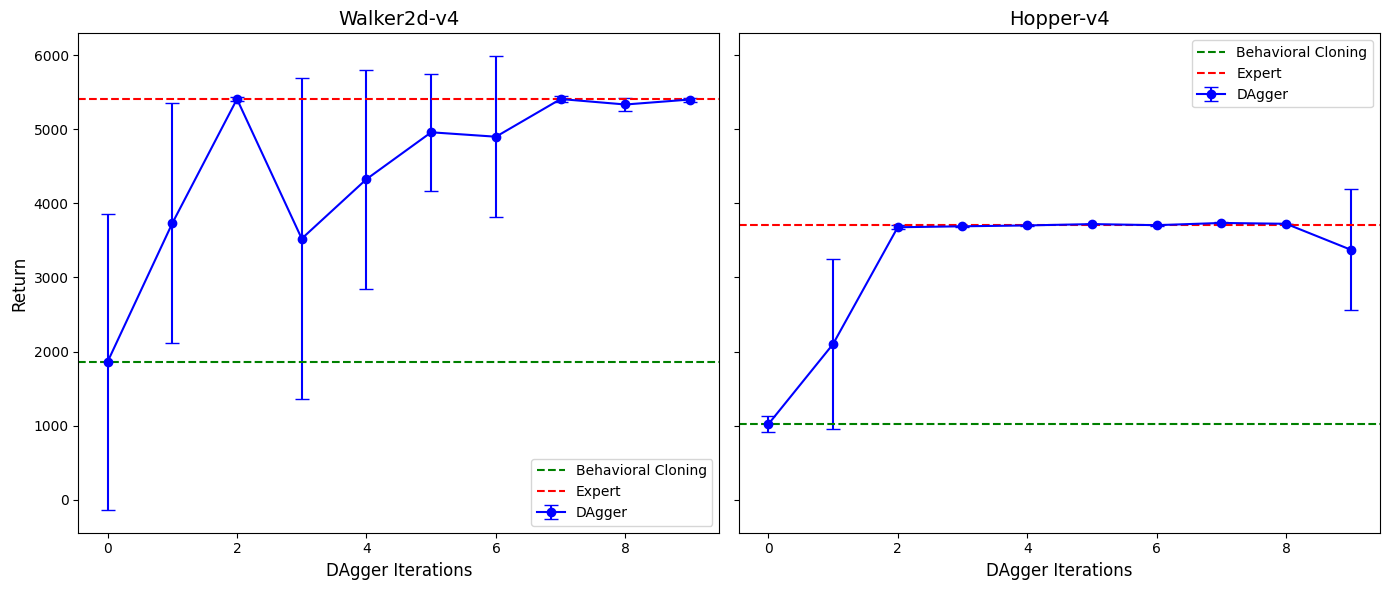

In [130]:
fig, axes = plt.subplots(1, len(env_names), figsize=(14, 6), sharey=True)

for i, env_name in enumerate(env_names):
    ax = axes[i]
    ax.errorbar(
        results[env_name]["iterations"],
        results[env_name]["dagger_mean"],
        yerr=results[env_name]["dagger_std"],
        fmt="-o",
        capsize=5,
        label="DAgger",
        color="blue",
    )

    ax.axhline(results[env_name]["bc_return"], linestyle="--", color="green", label="Behavioral Cloning")
    ax.axhline(results[env_name]["expert_return"], linestyle="--", color="red", label="Expert")

    ax.set_title(f"{env_name}-v4", fontsize=14)
    ax.set_xlabel("DAgger Iterations", fontsize=12)
    if i == 0:
        ax.set_ylabel("Return", fontsize=12)
    ax.legend()

plt.tight_layout()

output_file = "dagger_learning_curve.pdf"
plt.savefig(join(DATA_DIR, output_file), format='pdf')

plt.show()